### Imports

In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.dates as mdates

from scipy.spatial.distance import pdist, squareform

from sklearn.utils.extmath import cartesian

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
with open('dtypes_pre_process.pickle', 'rb') as fh:
    dtypes_pre = pickle.load(fh)
df_clean_path = '../capstone_train/df_clean.csv'
df_clean = pd.read_csv(df_clean_path, index_col=0).astype(dtypes_pre)
df_clean

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,...,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,cluster,hour,month,day_of_week,target
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00,True,NaN,NaN,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00,False,NaN,NaN,Male,18-24,NaN,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00,True,50.368247,-4.126646,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,devon-and-cornwall1,0,12,Sunday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,NaN,2,8,Wednesday,0
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29 21:00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,wiltshire8,21,8,Wednesday,1
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0


In [3]:
# Format station name
def beautify_station_name(station):
    station_spaced = station.replace('-',' ')
    capitalized_parts = station_spaced.split(" ")
    capitalized_parts[0] = capitalized_parts[0].capitalize()
    capitalized_parts[-1] = capitalized_parts[-1].capitalize()
    station_name_clean = " ".join(capitalized_parts)
    
    return station_name_clean

# Station success overtime

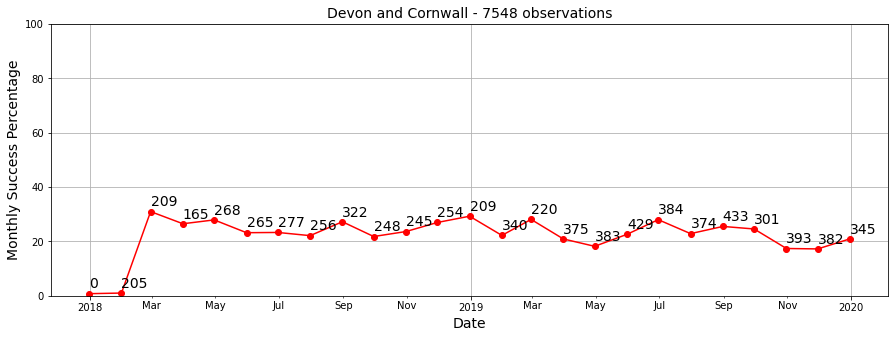

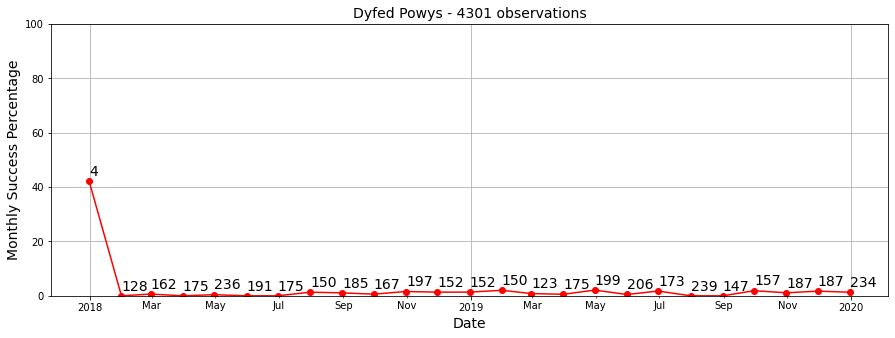

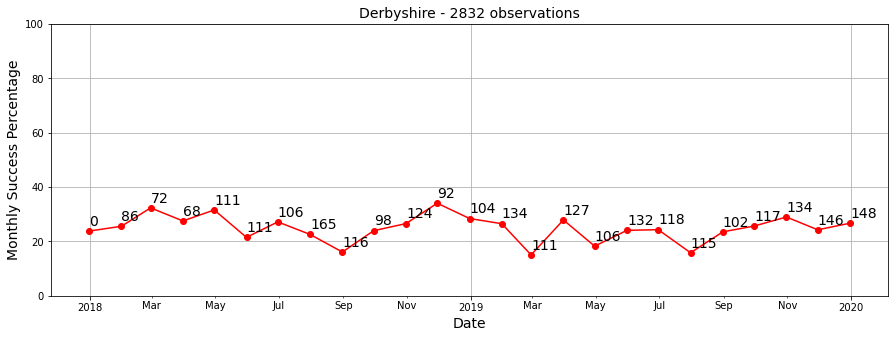

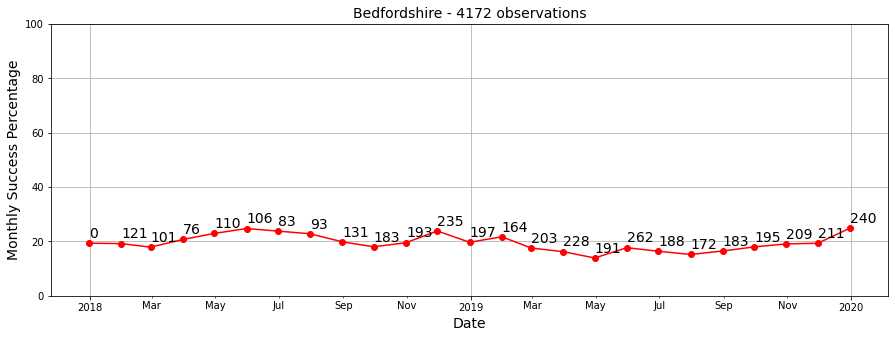

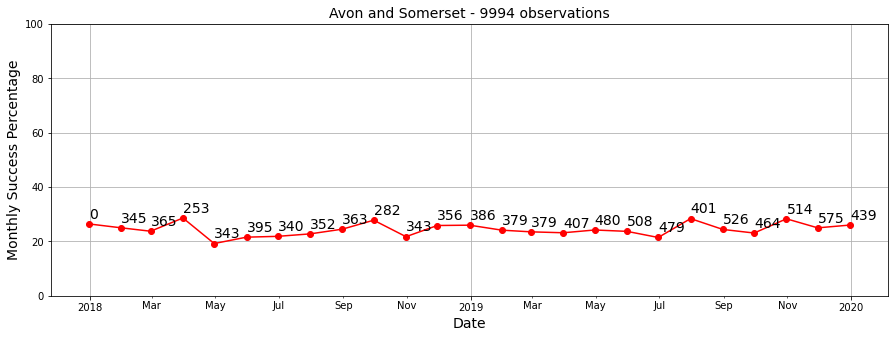

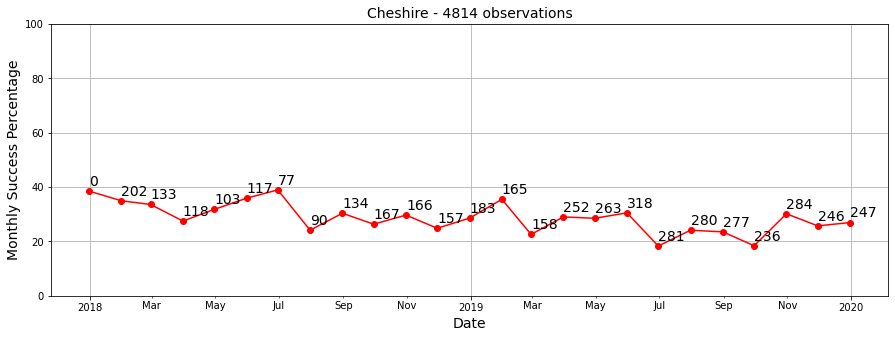

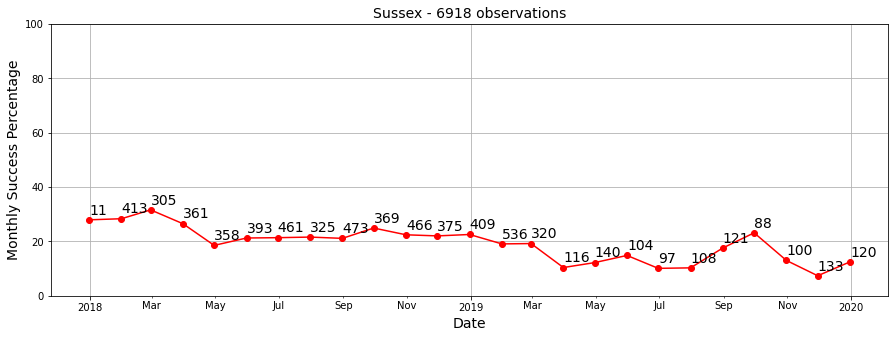

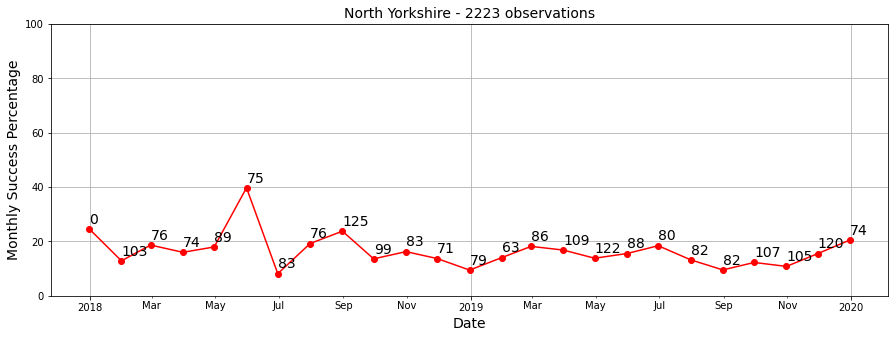

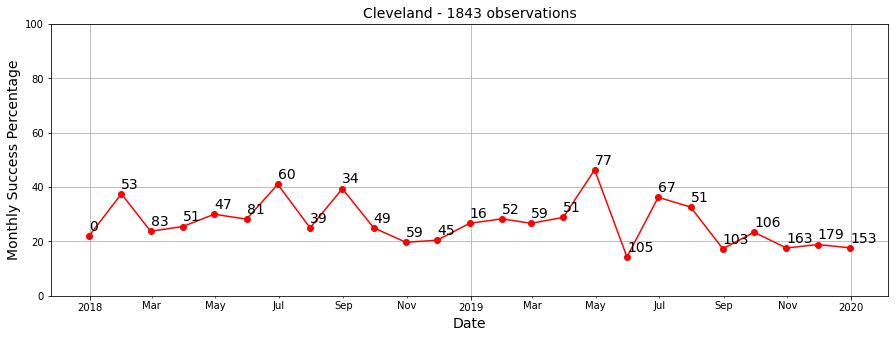

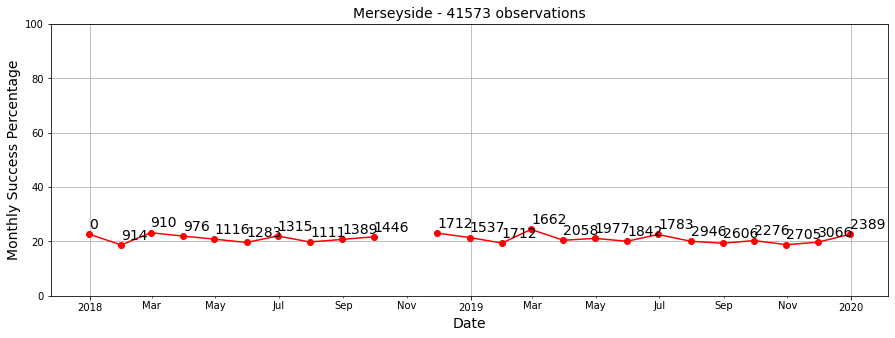

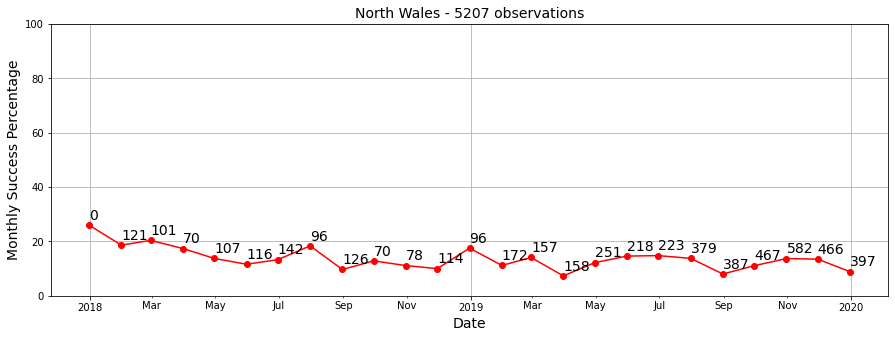

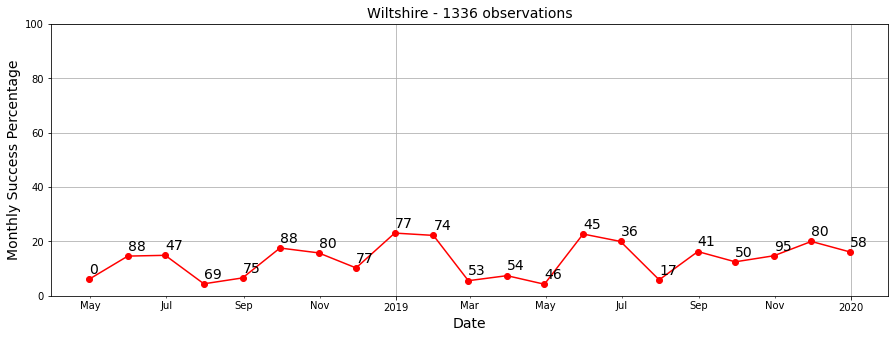

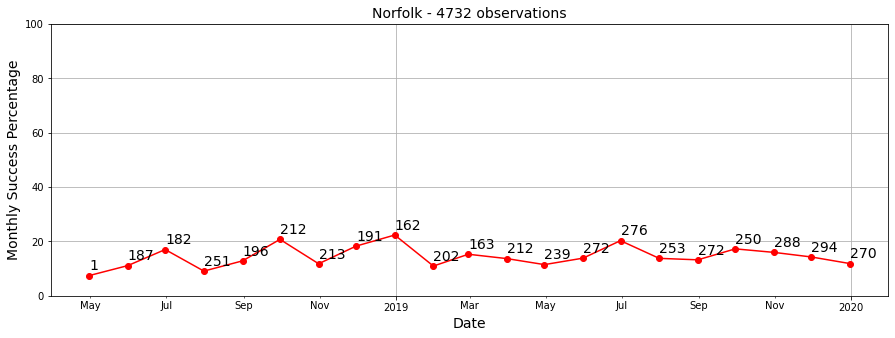

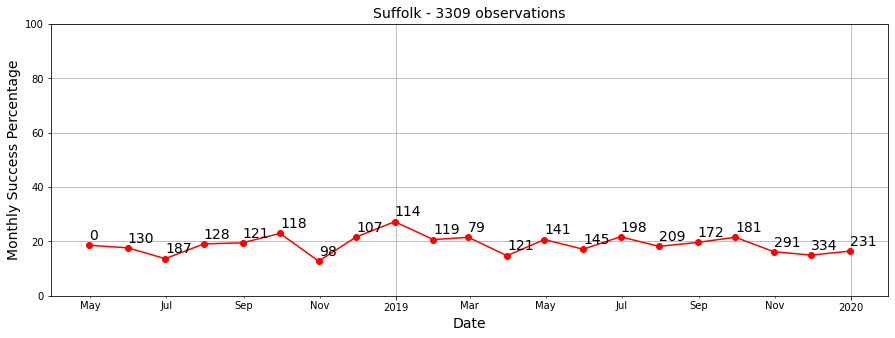

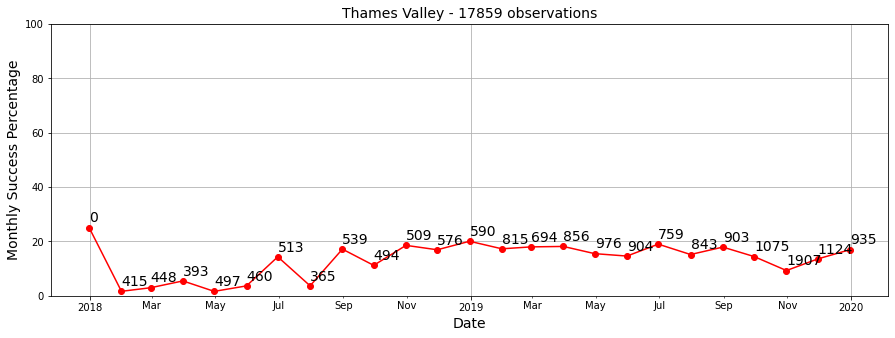

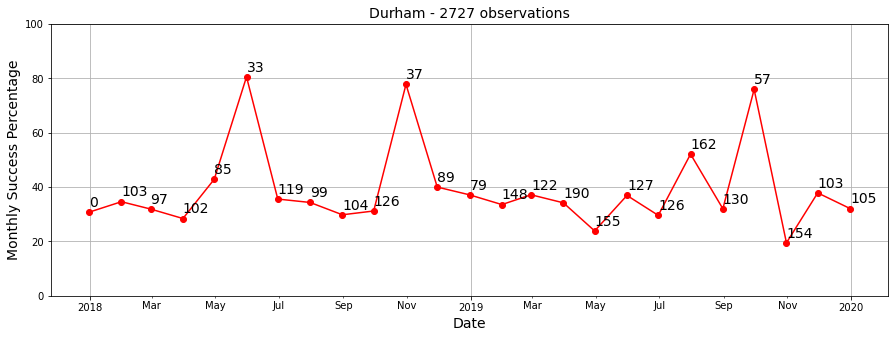

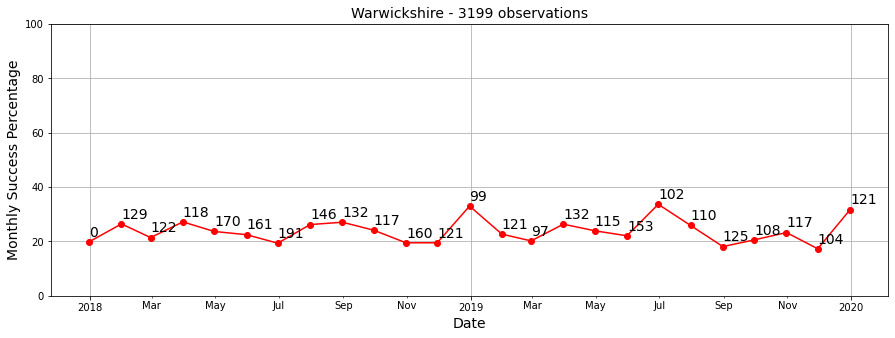

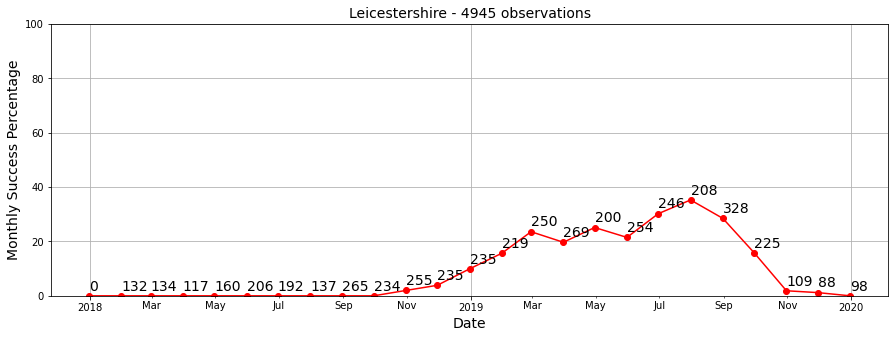

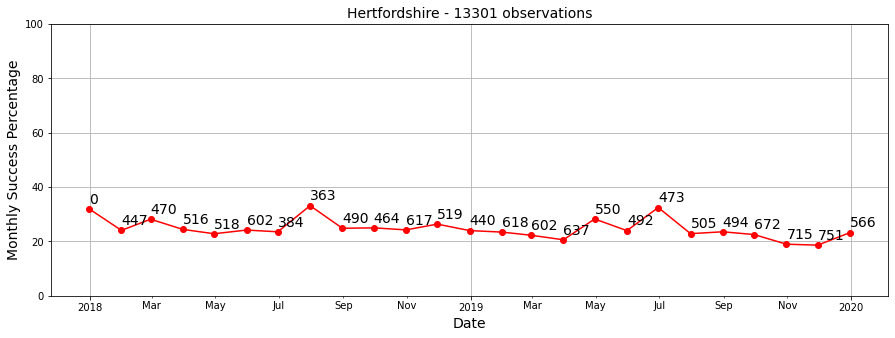

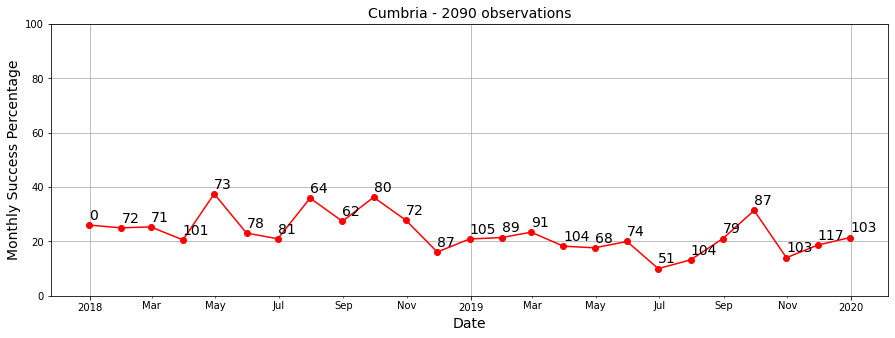

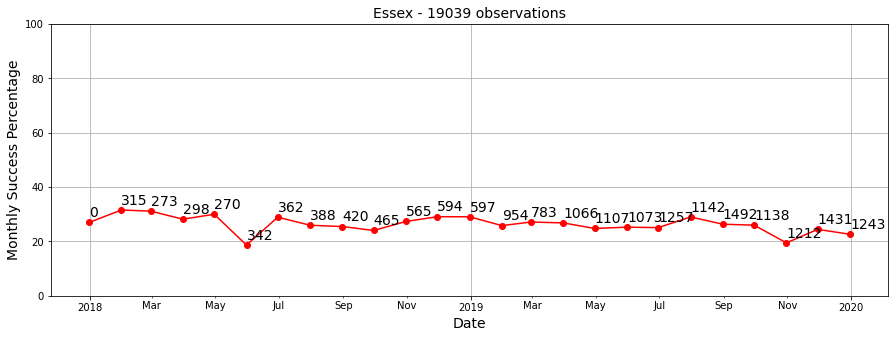

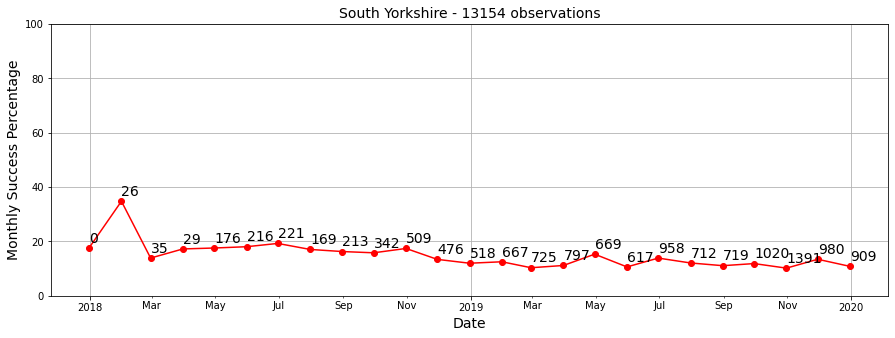

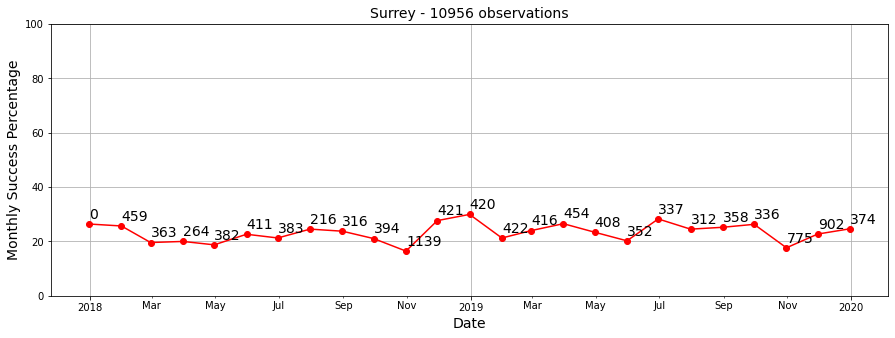

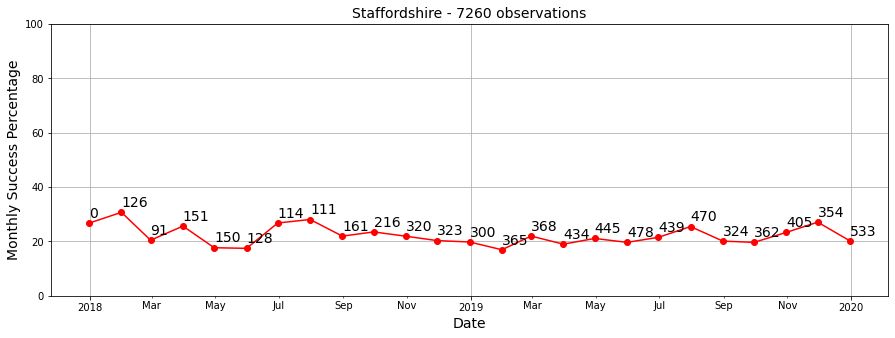

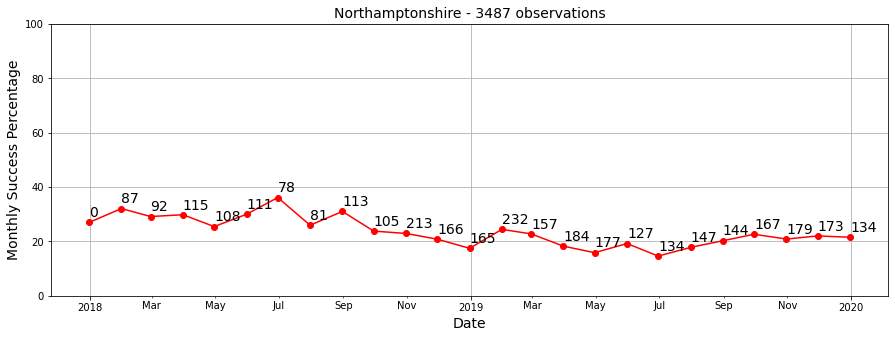

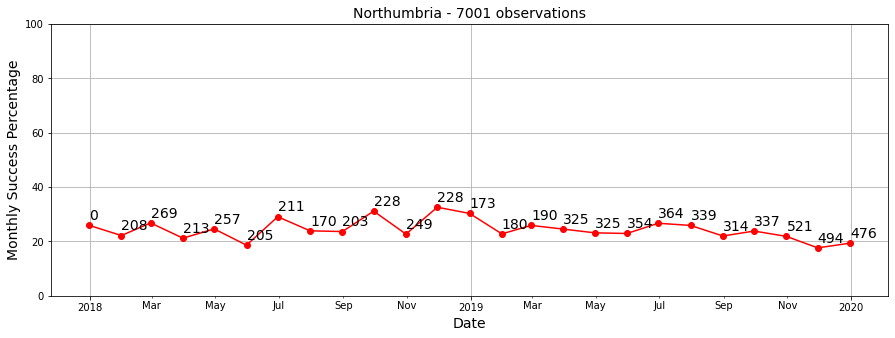

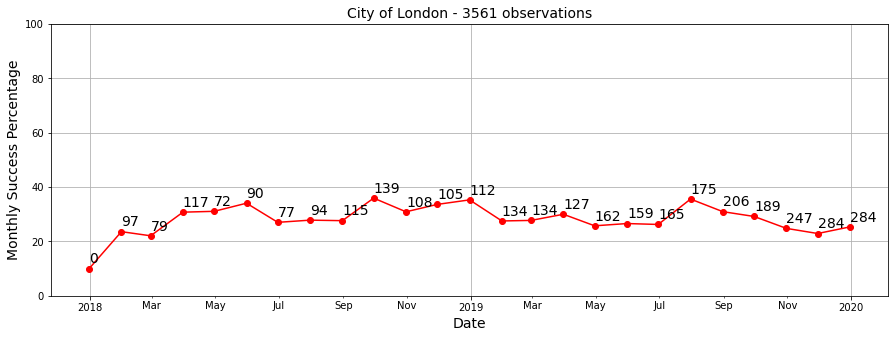

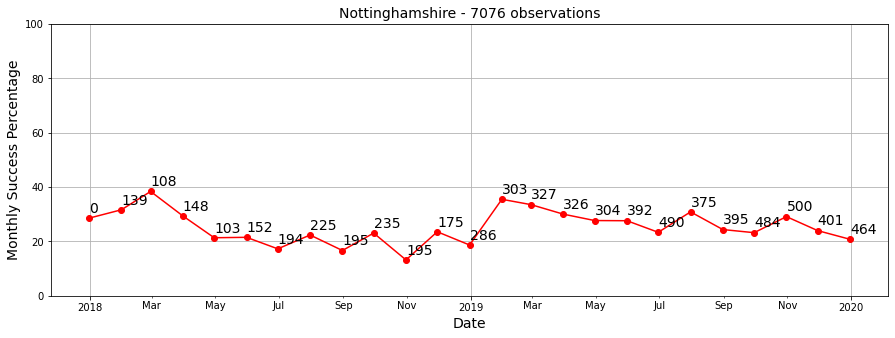

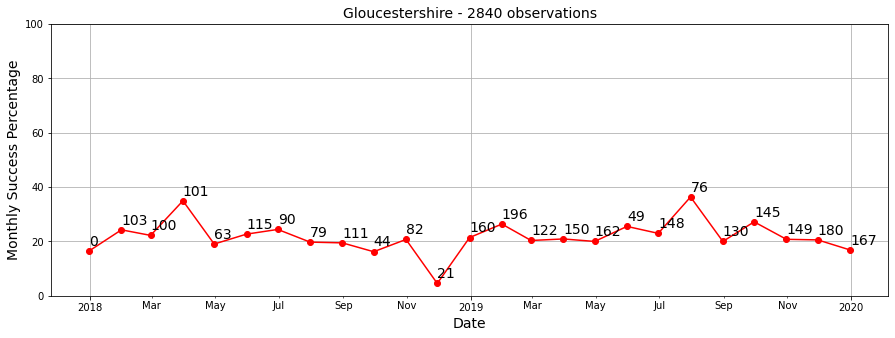

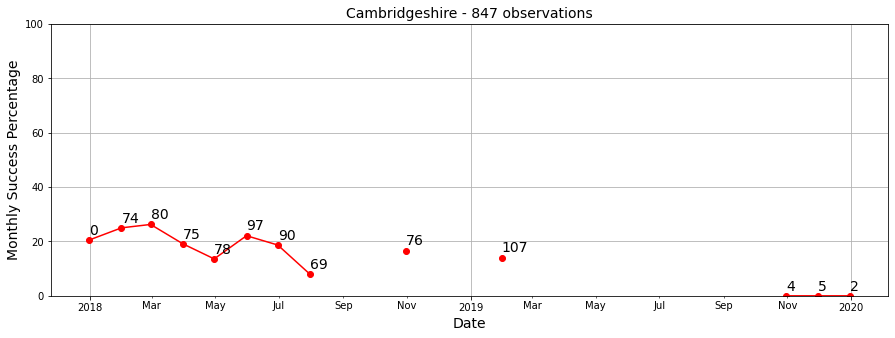

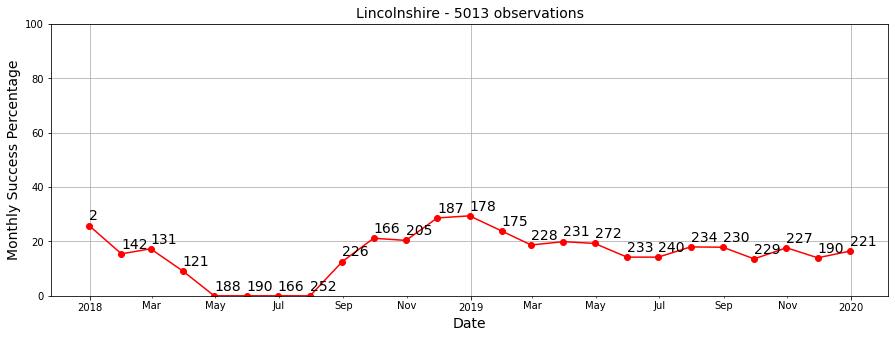

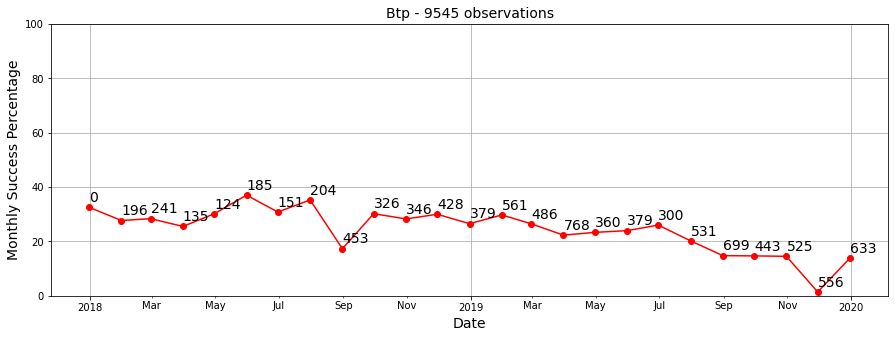

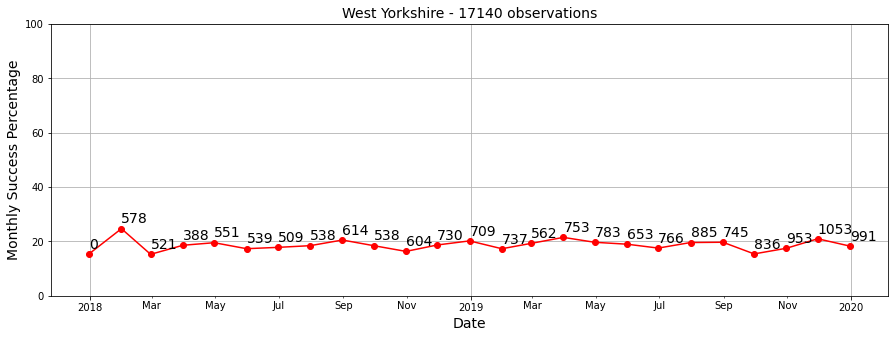

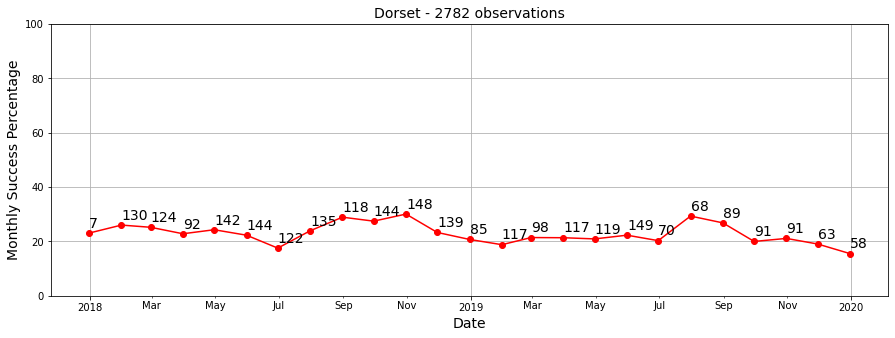

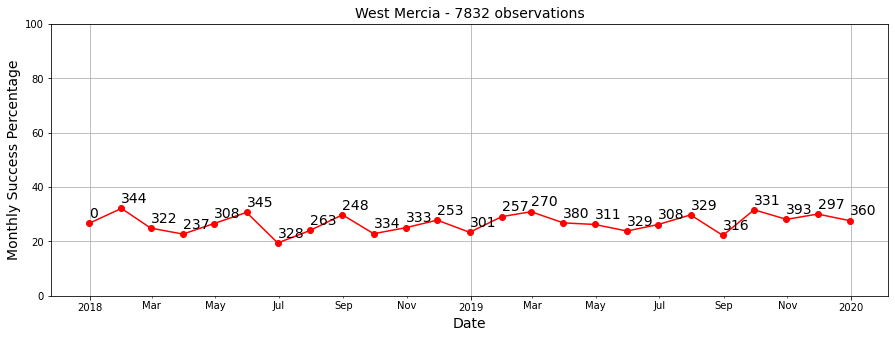

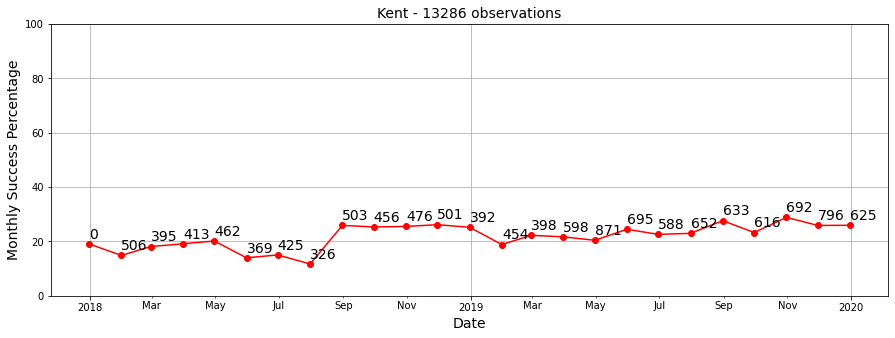

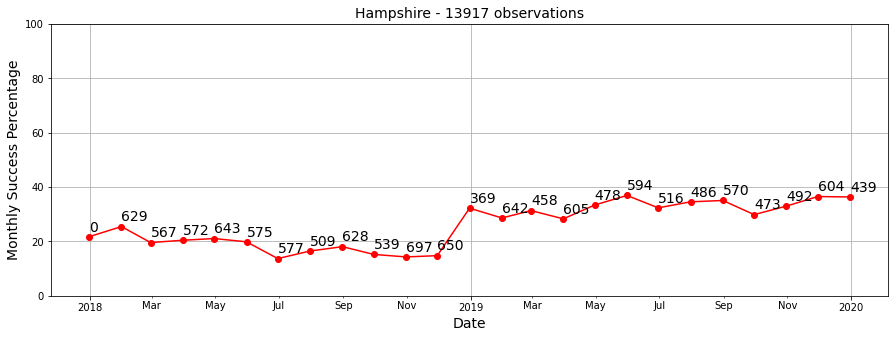

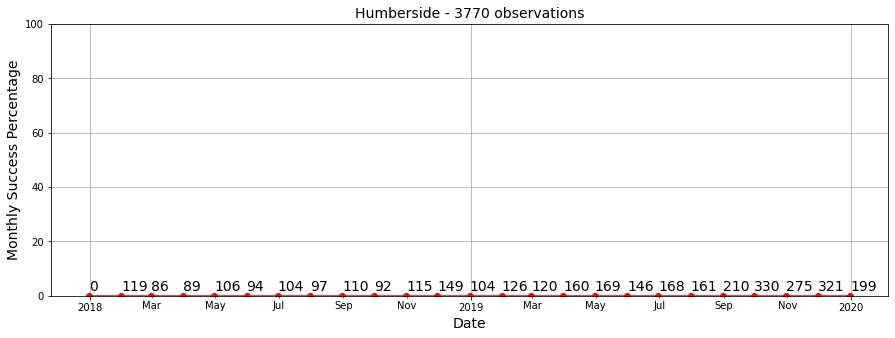

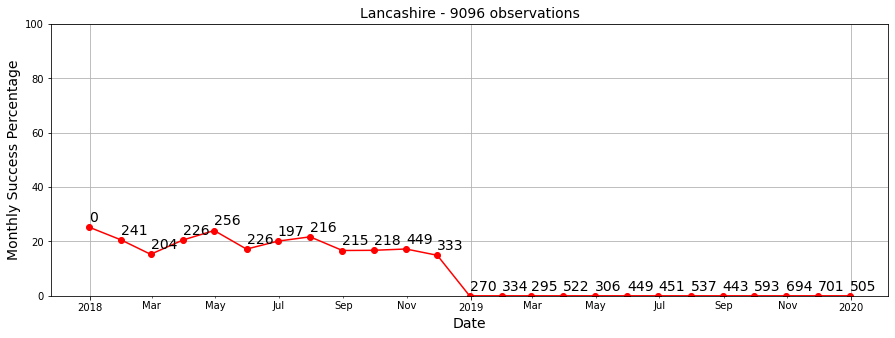

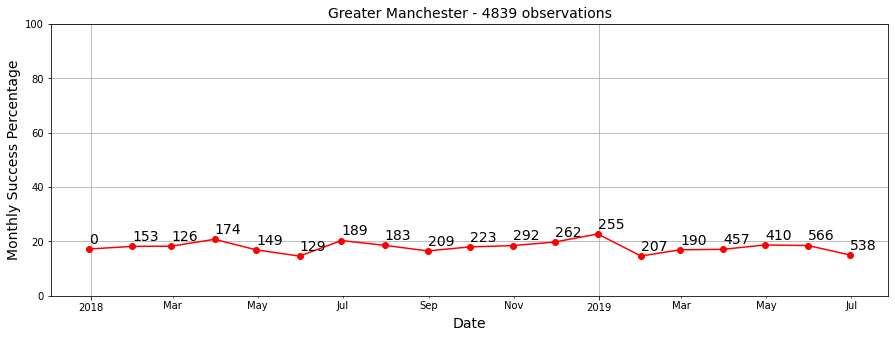

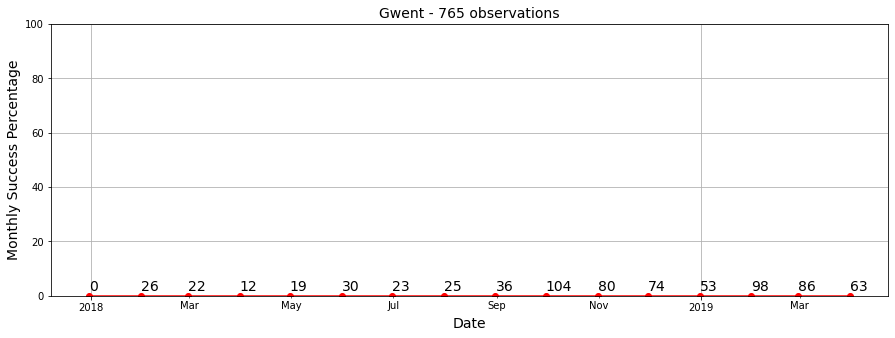

In [4]:
pat = df_clean.set_index('Date').sort_index()
pat.index = pd.to_datetime(pat.index)

for obj in df_clean.station.unique():
    df_sta = pat[pat['station'] == obj].copy()
    station_obser = df_sta.shape[0]

    # resample to monthly
    # target = average_success_rate | sucess_total/search_total = target.mean
    df_sta_resampled = df_sta.resample('M').mean()
    df_sta_resampled['target'] = df_sta_resampled['target'].apply(lambda x: x*100)
        
    #display(df_sta['target'])
    fig, ax = plt.subplots(figsize =(15, 5))
    ax.set_ylim(0, 100)
    
    locator = mdates.AutoDateLocator(minticks=8, maxticks=15)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_minor_locator(locator)
    ax.xaxis.set_minor_formatter(formatter)

    # format the ticks
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
     
    # n_operations = pat[pd.to_datetime(df_sta.index.min()):pd.to_datetime(df_sta.index.max())].shape[0]
    previous_date = pd.to_datetime(df_sta_resampled.index.min())
    for i, y in enumerate(df_sta_resampled['target']):

        point_date = pd.to_datetime(df_sta_resampled.index[i])
        n_operations = df_sta.loc[previous_date:point_date].shape[0]
        previous_date = point_date
        
        ax.annotate(n_operations, (df_sta_resampled['target'].index[i], y+2), fontsize=14)
    
    plt.plot(df_sta_resampled.index, df_sta_resampled['target'], color='red', marker='o')
    plt.title(beautify_station_name(obj) + f' - {station_obser} observations', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Monthly Success Percentage', fontsize=14)
    plt.grid(True)

    plt.show()

## Plot station where Legistation and Removal is missing / graph stuff

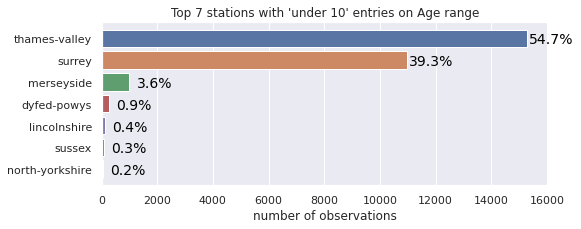

In [5]:
# show the most common feature values for all the categorical features
categorical_features = df_clean.columns.drop(['observation_id', 'Date', 'Latitude', 'Longitude'])
#ages = df_clean[pd.isna(df_clean['Removal of more than just outer clothing'])]
ages = df_clean[pd.isna(df_clean['Legislation'])]
for feature in ['station']:
    #df_clean[feature] = df_clean[feature].fillna('Missing')
    
    sns.set(rc={'figure.figsize':(8,3)})
    fig, ax = plt.subplots() #figsize=(15,8)
    sns.countplot(ax=ax, y=feature, data=ages, order=pd.value_counts(ages[feature]).iloc[:7].index).set(
        title='Top 7 stations with \'under 10\' entries on Age range')
    
    ax.set(xlabel="number of observations", ylabel = "")

    bars = len(ax.patches)
    total = len(ages[feature])
    for p in ax.patches:

        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        ax.annotate(f'\n{percentage}', xy=(0 + p.get_width(), p.get_y()),  
                    ha='center', va='top', color='black', size=14, xytext=(25,6.5+bars), textcoords='offset points')

        ax1_lim = ((0, 0), (p.get_width()+3, p.get_y()))
        ax.update_datalim(ax1_lim)
        ax.autoscale()

In [6]:
# raise SystemExit("Stop here")

## Plot percentage of cloth removal in each police station for each gender

In [7]:
# for each station
station_list = df_clean.station.unique()
gender_list = df_clean.Gender.unique()[:2]
ethnicity_list = df_clean['Officer-defined ethnicity'].unique()
age_list = df_clean['Age range'].unique()

In [8]:
print('Percentage of cloth removal in each police station for each gender')
data = []
for s in station_list:
    # for each gender
    for g in gender_list:
        
        # nº revisões por station e gender
        n_total = df_clean.loc[(df_clean.station == s) & (df_clean.Gender == g)].shape[0]
        
        # check for stop discrimination
        g_rem = df_clean.loc[(df_clean.station == s) & (df_clean.Gender == g) & (df_clean['Removal of more than just outer clothing'] == True)].shape[0]
        
        rem_g_percent = round(g_rem / n_total * 100, 2)
        
        data.append([s, g, rem_g_percent])

        #print(f"{g}: {rem_g_percent}")
    
df_remove = pd.DataFrame(data, columns=['station', 'Gender', 'percentage'])

Percentage of cloth removal in each police station for each gender


In [9]:
df_remove

,station,Gender,percentage
0,devon-and-cornwall,Male,1.71
1,devon-and-cornwall,Female,3.03
2,dyfed-powys,Male,7.80
3,dyfed-powys,Female,11.65
4,derbyshire,Male,7.81
...,...,...,...
77,lancashire,Female,6.92
78,greater-manchester,Male,2.24
79,greater-manchester,Female,3.55
80,gwent,Male,0.00


In [10]:
top_n = 10
difff = abs(df_remove['percentage'].diff())
idexx = difff[1::2].sort_values(ascending=False).index[:top_n]
dif_to_plot = difff[1::2].sort_values(ascending=False)[:top_n]
order = df_remove.iloc[idexx]['station'].values
top_10_diff = df_remove[df_remove.station.isin(df_remove.iloc[idexx]['station'])]

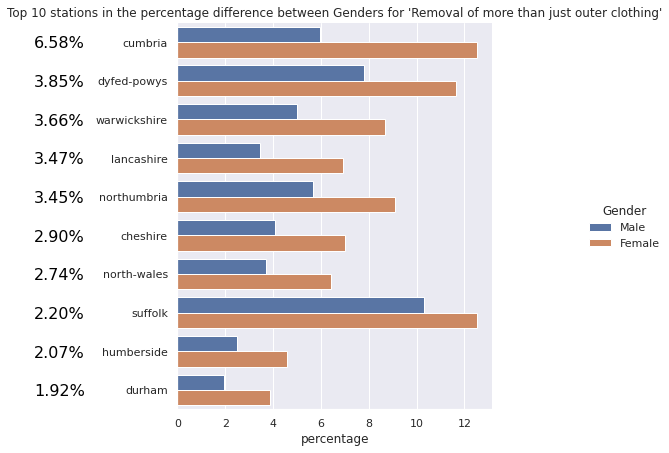

In [11]:
sns.set_style("darkgrid")
g = sns.catplot(data=top_10_diff, kind="bar", x="percentage", y="station", hue="Gender", orient="h", height=6, order = order).set(title='Top 10 stations in the percentage difference between Genders for \'Removal of more than just outer clothing\'')
g.set(xlabel="percentage", ylabel = "")

ax = g.facet_axis(0,0)
for i ,p in enumerate(ax.patches):
    if i<10:
        percent = round(dif_to_plot.iloc[i],2)
        ax.text(p.get_x() -6, p.get_y()+0.55, f"{percent:.2f}%",  color='black', rotation='horizontal', size=16)

### create Gender / Ethicity / Age sets

In [12]:
# data = []
# for station in station_list:
#     for ethnicity in ethnicity_list:
#         for gender in gender_list:
#             for age in age_list:

#                 # nº revisões por departamento e gender
#                 n_total = df_clean.loc[(df_clean['station'] == station) &
#                                        (df_clean['Officer-defined ethnicity'] == ethnicity) & 
#                                  (df_clean.Gender == gender) & (df_clean['Age range'] == age)].shape[0]

#                 #print(n_total)
#                 if n_total < 30 :
#                     continue
#                 # check for stop discrimination
#                 g_rem = df_clean.loc[(df_clean['station'] == station) &
#                                      (df_clean['Officer-defined ethnicity'] == ethnicity) & 
#                                  (df_clean.Gender == gender) & (df_clean['Age range'] == age) & (df_clean['target'] == 1)].shape[0]

#                 rem_g_percent = round(g_rem / n_total * 100, 2)

#                 data.append([station, ethnicity, gender, age, rem_g_percent, n_total])

#                 #print(f"{g}: {rem_g_percent}")
    
# df_remove_comb2 = pd.DataFrame(data, columns=['station', 'Officer-defined ethnicity', 'Gender', 'Age range', 'percentage success', 'total'])

In [13]:
# save to file and load them for the next times because it takes too much time to create

In [14]:
df_clean_path = '../capstone_train/df_discri.csv'
# save
#df_remove_comb2.to_csv(df_clean_path, index=True)
# load
df_clean_discri = pd.read_csv(df_clean_path, index_col=0)
df_clean_discri2 = df_clean_discri[df_clean_discri.total>30]
df_clean_discri2

,station,Officer-defined ethnicity,Gender,Age range,percentage success,total
0,devon-and-cornwall,Asian,Male,18-24,21.88,32
5,devon-and-cornwall,White,Male,18-24,29.77,1733
6,devon-and-cornwall,White,Male,25-34,24.15,1474
7,devon-and-cornwall,White,Male,over 34,20.54,1704
8,devon-and-cornwall,White,Male,10-17,11.31,1123
...,...,...,...,...,...,...
987,greater-manchester,Other,Male,18-24,25.64,39
995,gwent,White,Male,18-24,0.00,226
996,gwent,White,Male,25-34,0.00,160
997,gwent,White,Male,over 34,0.00,118


In [15]:
df_clean_max_min = df_clean_discri2.copy()

df_clean_max_min['combined'] = "(" + df_clean_max_min['Officer-defined ethnicity'] + ", " + df_clean_max_min['Gender']  + ", " + df_clean_max_min['Age range'] + ")" 
df_clean_max_min = df_clean_max_min.drop(columns=['Officer-defined ethnicity', 'Gender', 'Age range'])

df_new = pd.DataFrame(columns=['station', 'percentage success', 'total', 'combined'])
for s in df_clean_max_min.station.unique():
    df_station = df_clean_max_min[df_clean_max_min.station == s]

    cond1 = df_station['percentage success'] == df_station['percentage success'].min()
    cond2 = df_station['percentage success'] == df_station['percentage success'].max()
    df_max_min = df_station[cond1|cond2]
    df_new = df_new.append(df_max_min)

df_new

,station,percentage success,total,combined
13,devon-and-cornwall,7.05,227,"(White, Female, 10-17)"
17,devon-and-cornwall,31.91,47,"(Black, Male, over 34)"
33,dyfed-powys,5.26,190,"(White, Female, 18-24)"
34,dyfed-powys,0.00,151,"(White, Female, 25-34)"
45,derbyshire,37.40,131,"(Asian, Male, 18-24)"
...,...,...,...,...
978,greater-manchester,27.18,298,"(Black, Male, 18-24)"
995,gwent,0.00,226,"(White, Male, 18-24)"
996,gwent,0.00,160,"(White, Male, 25-34)"
997,gwent,0.00,118,"(White, Male, over 34)"


(0.0, 80.0)

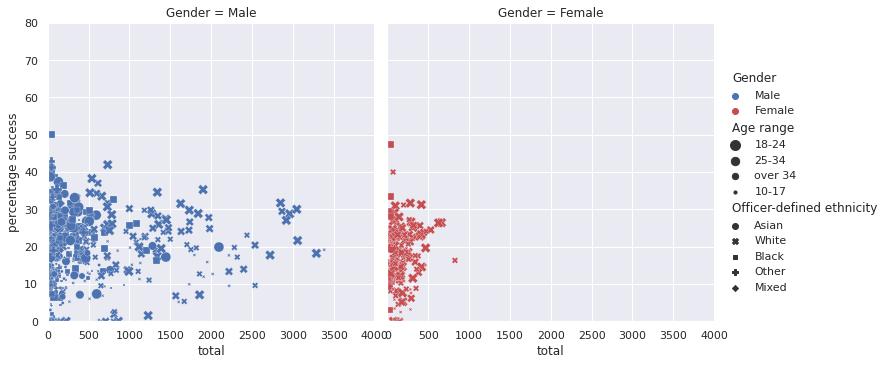

In [16]:
lm = sns.relplot(
    data=df_clean_discri2, x="total", y="percentage success", col="Gender",
    hue="Gender", size="Age range", style="Officer-defined ethnicity",
    palette=["b", "r"], sizes=(10, 100),
)
axes = lm.axes
axes[0,0].set_ylim(0,60)
axes[0,0].set_xlim(0,4000)
axes[0,1].set_ylim(0,80)

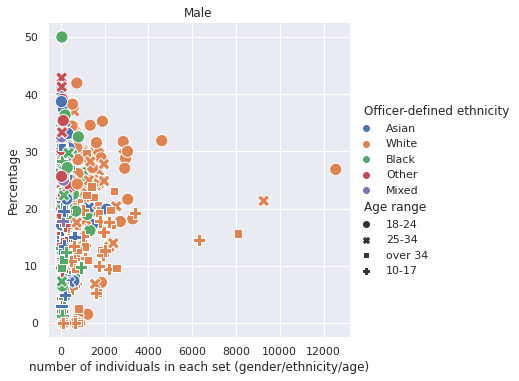

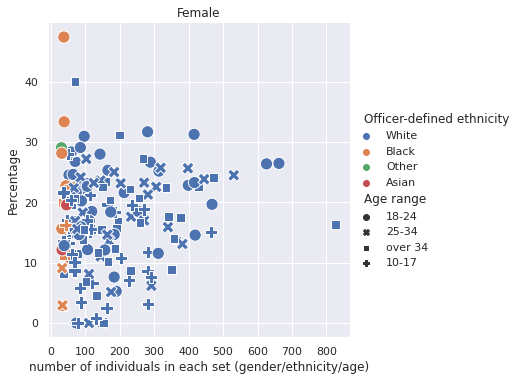

In [17]:
d_plot = df_clean_discri2[df_clean_discri2.Gender == 'Male']
sns.relplot(x="total", y="percentage success", hue="Officer-defined ethnicity", style="Age range", data=d_plot, s=150, height=5).set(title='Male').set_axis_labels("number of individuals in each set (gender/ethnicity/age)", "Percentage")
d_plot = df_clean_discri2[df_clean_discri2.Gender == 'Female']
sns.relplot(x="total", y="percentage success", hue="Officer-defined ethnicity", style="Age range", data=d_plot, s=150).set(title='Female').set_axis_labels("number of individuals in each set (gender/ethnicity/age)", "Percentage")

## Sucess rate of Juliana

In [18]:
print('Success Rate on Black,Mixed, Male, 18-24, 25,34')
data = []
for ethnicity in ['White', 'Black', 'Mixed']:
    for gender in ['Male']:
        for age in ['18-24', '25-34']:

            # nº revisões por departamento e gender
            cond1 = df_clean['Officer-defined ethnicity'] == ethnicity
            cond2 = df_clean['Gender'] == gender
            cond3 = df_clean['Age range'] == age
            n_total = df_clean.loc[cond1&cond2&cond3].shape[0]

            #print(df_clean.loc[cond2].shape[0])
            if n_total < 100 :
                continue
            g_rem = df_clean.loc[(df_clean['Officer-defined ethnicity'] == ethnicity) & 
                             (df_clean.Gender == gender) & (df_clean['Age range'] == age) & (df_clean['target'] == 1)].shape[0]

            rem_g_percent = round(g_rem / n_total * 100, 2)

            data.append([ethnicity, gender, age, rem_g_percent, n_total])

    
df_july = pd.DataFrame(data, columns=['Officer-defined ethnicity', 'Gender', 'Age range', 'success rate', 'total'])

Success Rate on Black,Mixed, Male, 18-24, 25,34


In [19]:
df_july

,Officer-defined ethnicity,Gender,Age range,success rate,total
0,White,Male,18-24,25.57,69755
1,White,Male,25-34,21.62,52240
2,Black,Male,18-24,23.07,12826
3,Black,Male,25-34,23.47,6718
4,Mixed,Male,18-24,23.95,643
5,Mixed,Male,25-34,24.44,360


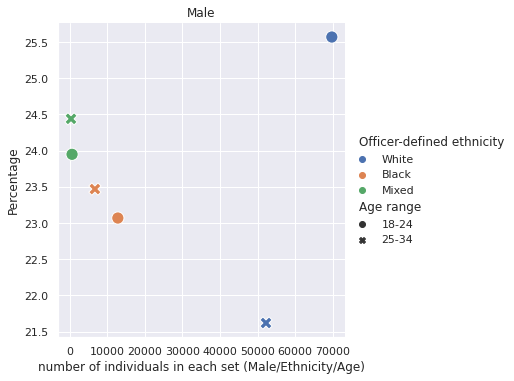

In [20]:
d_plot = df_july[df_july.Gender == 'Male']
sns.relplot(x="total", y="success rate", hue="Officer-defined ethnicity", style="Age range", data=d_plot, s=150, height=5).set(title='Male').set_axis_labels("number of individuals in each set (Male/Ethnicity/Age)", "Percentage")

In [21]:
df_clean

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,...,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,cluster,hour,month,day_of_week,target
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00,True,NaN,NaN,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00,False,NaN,NaN,Male,18-24,NaN,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00,True,50.368247,-4.126646,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,devon-and-cornwall1,0,12,Sunday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,NaN,2,8,Wednesday,0
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29 21:00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,wiltshire8,21,8,Wednesday,1
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0


# Percentage of cloth removal in gender, ethnicity, age

In [22]:
print('Percentage of cloth removal in gender, ethnicity, age')
# for each station
data = []

for ethnicity in ethnicity_list:
    for gender in gender_list:
        for age in age_list:


            # check for stop discrimination
            g_rem = df_clean.loc[(df_clean['Officer-defined ethnicity'] == ethnicity) & 
                             (df_clean.Gender == gender) & (df_clean['Age range'] == age) & 
                                 (df_clean['Removal of more than just outer clothing'] == True)].shape[0]

            # nº revisões por departamento e gender
            n_total = df_clean.loc[(df_clean['Officer-defined ethnicity'] == ethnicity) & 
                             (df_clean.Gender == gender) & (df_clean['Age range'] == age)].shape[0]

            #print(n_total)
            if n_total < 100 :
                continue
                
            rem_g_percent = round(g_rem / n_total * 100, 2)

            data.append([ethnicity, gender, age, rem_g_percent, n_total])

    
df_remove_comb = pd.DataFrame(data, columns=['Officer-defined ethnicity', 'Gender', 'Age range', 'percentage', 'total'])

Percentage of cloth removal in gender, ethnicity, age


In [23]:
df_remove_comb

,Officer-defined ethnicity,Gender,Age range,percentage,total
0,Asian,Male,18-24,4.65,10880
1,Asian,Male,25-34,3.73,6353
2,Asian,Male,over 34,3.73,2972
3,Asian,Male,10-17,2.79,3758
4,Asian,Female,18-24,3.20,250
5,Asian,Female,25-34,3.97,151
6,White,Male,18-24,2.81,69755
7,White,Male,25-34,3.37,52240
8,White,Male,over 34,3.39,50514
9,White,Male,10-17,1.17,42929


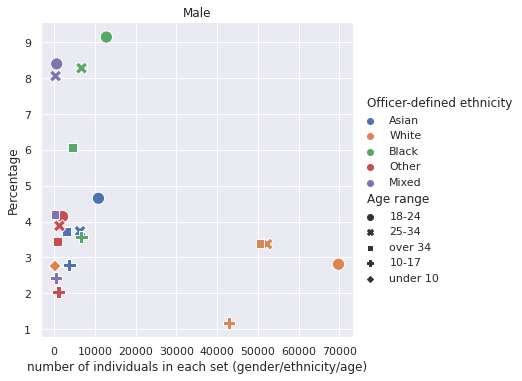

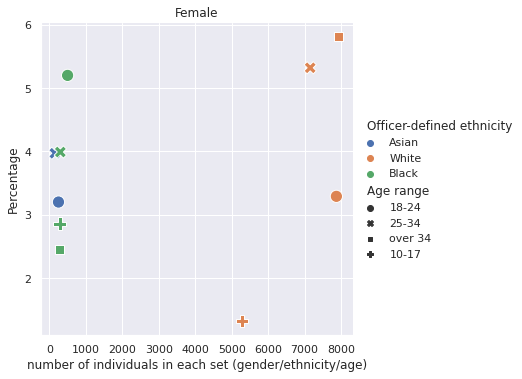

In [24]:
d_plot = df_remove_comb[df_remove_comb.Gender == 'Male']
sns.relplot(x="total", y="percentage", hue="Officer-defined ethnicity", style="Age range", data=d_plot, s=150, height=5).set(title='Male').set_axis_labels("number of individuals in each set (gender/ethnicity/age)", "Percentage")
d_plot = df_remove_comb[df_remove_comb.Gender == 'Female']
sns.relplot(x="total", y="percentage", hue="Officer-defined ethnicity", style="Age range", data=d_plot, s=150).set(title='Female').set_axis_labels("number of individuals in each set (gender/ethnicity/age)", "Percentage")

In [25]:
print('average_sucess = average_success_rate =  average_sucess_fail')

# for st in station_list:
    
#     df_station = df[df['station'] == st]
    
#     # nº revisões por departamento e gender
#     search_total = df_station.shape[0]
#     sucess_total = df_station.loc[df_station.target == 1].shape[0]
#     fail_total = df_station.loc[df_station.target == 0].shape[0]

    
#     average_success_rate = sucess_total/search_total
#     average_sucess_fail = df_station.target.mean()
#     print(st)
#     print('average_success_rate: ', average_success_rate, ', average_sucess_fail: ', average_sucess_fail, '\n') 

average_sucess = average_success_rate =  average_sucess_fail
